In [1]:
import cv2
import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from tqdm import tqdm
import wandb

In [2]:
from causal_world.task_generators.task import generate_task
from causal_world.envs.causalworld import CausalWorld


In [3]:
class FrameStack(gym.Wrapper):
    
    """
    stack multiple frames together 
    as done in the Nature paper and later work.
    allow for single goal observation, i.e,
    get a single frame of goal obs for each view, 
    because the consecutive frames of goal obs does not provide
    dynamic information to the agent, i.e, goal object doesn't move
    
    

    :param env: Environment to wrap
    :param k: frames that stack together
    :param single_goal_obs: flag that control how many 
     frames of goal obs to stack
    """
    def __init__(self, env, k, single_goal_obs = True):
        gym.Wrapper.__init__(self, env)
        self._k = k
        self.single_goal_obs = single_goal_obs
        self._frames = deque([], maxlen=k)
        self.shp = env.observation_space.shape
        self.num_view = int(self.shp[0]/2)
        # default channel is 1 (for Grayscale obs)
        self.num_channel = 1                   
        
        # reshape of the obs if it's RGB and 
        # change the number of channel 
        if len(self.shp) == 4:
            self.shp = (self.shp[0] * self.shp[-1], self.shp[1], self.shp[2])
            self.num_channel = 3
            
        if self.single_goal_obs:
            shape = ((self.num_view * self.num_channel * (k + 1),) + self.shp[1:])
        else:
            shape = ((self.shp[0] * k,) + self.shp[1:])
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape=shape,
            dtype=env.observation_space.dtype
        )
        

    def reset(self):
        obs = self.env.reset()
        # reshape the initial obs
        obs = obs.reshape(self.shp)
        for _ in range(self._k):
            self._frames.append(obs)
        return self._get_obs()

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
         # reshape the obs
        obs = obs.reshape(self.shp)
        self._frames.append(obs)
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        assert len(self._frames) == self._k
        
        frames_target = []
        frames_goal = []
        # extract the target obs and goal obs to seperate list 
        for i in range(self._k):
            for j in range(self.shp[0]):
                if j < self.shp[0]/2:
                    frames_target.append(self._frames[i][j])
                else:
                    frames_goal.append(self._frames[i][j])
        # merge the two target obs list and goal obs list
        # each element in the list is multiple views of the object 
        last_frames = []
        if self.single_goal_obs:
            # only merge one frame from different view of goal
            for i in range(int(len(frames_goal)/self._k)):
                last_frames.append(frames_goal[i])
        else:
            last_frames = frames_goal
        return np.concatenate((frames_target,last_frames), axis=0)

In [4]:
class ResizeFrame(gym.ObservationWrapper):
    """
    warp frames to 84x84 (default)
    as done in the Nature paper and later work.

    :param env: Environment to wrap
    :param width: New frame width
    :param height: New frame height
    """

    def __init__(self, env: gym.Env, max_episode_length, width: int = 84, height: int = 84) -> None:
        super().__init__(env)
        self.width = width
        self.height = height
        assert isinstance(env.observation_space, gym.spaces.Box), f"Expected Box space, got {env.observation_space}"
        #self._max_episode_steps = max_episode_length
        if len(env.observation_space.shape) == 4:
            self.observation_space = gym.spaces.Box(
                low=0,
                high=1,
                shape=(env.observation_space.shape[0], self.height, self.width, env.observation_space.shape[-1]),
                dtype=env.observation_space.dtype,  # type: ignore[arg-type]
            )
        if len(env.observation_space.shape) == 3:
            self.observation_space = gym.spaces.Box(
                low=0,
                high=1,
                shape=(env.observation_space.shape[0], self.height, self.width),
                dtype=env.observation_space.dtype,  # type: ignore[arg-type]
            )
        

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation
        """
        assert cv2 is not None, "OpenCV is not installed, you can do `pip install opencv-python`"
        
        new_frame = np.empty(self.observation_space.shape, dtype = self.observation_space.dtype)
        for i in range(len(frame)):
            new_frame[i] = cv2.resize(frame[i], (self.width, self.height), interpolation=cv2.INTER_AREA)
        return new_frame

In [5]:
class GrayFrame(gym.ObservationWrapper):
    """
    Convert frames to gray scale (default)
    as done in the Nature paper and later work.

    :param env: Environment to wrap
    :param width: New frame width
    :param height: New frame height
    """

    def __init__(self, env: gym.Env, max_episode_length) -> None:
        super().__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Box), f"Expected Box space, got {env.observation_space}"
        
        #self._max_episode_steps = max_episode_length
        if len(env.observation_space.shape) == 3:
            return
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape= env.observation_space.shape[:3],
            dtype=env.observation_space.dtype,  # type: ignore[arg-type]
        )
        

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation
        """
        assert cv2 is not None, "OpenCV is not installed, you can do `pip install opencv-python`"
        
        if self.observation_space.dtype != 'uint8':
            frame = np.float32(frame)
        new_frame = np.empty(self.observation_space.shape, dtype = self.observation_space.dtype)
        for i in range(len(frame)):
            new_frame[i] = cv2.cvtColor(frame[i], cv2.COLOR_RGB2GRAY) 


        return new_frame    

In [6]:
# adapted from stable_baselines3/common/atari_wrappers.py

class DtypeChange(gym.ObservationWrapper):
    """
    Convert data type to uint8 (default)

    :param env: Environment to wrap
    :param type: data type

    """

    def __init__(self, env: gym.Env, dtype = 'uint8') -> None:
        super().__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Box), f"Expected Box space, got {env.observation_space}"
        
        if len(env.observation_space.shape) == 3:
            return
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape= env.observation_space.shape,
            dtype=dtype,  # type: ignore[arg-type]
        )
        

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation
        """
        assert cv2 is not None, "OpenCV is not installed, you can do `pip install opencv-python`"
        
        frame = frame * 255
        frame = frame.astype(np.uint8)

        return frame

In [7]:
def make_env(task_name, skip_frame, seed, maximum_episode_length, observation_mode, capture_video, run_name):
    def thunk():
        
        task = generate_task(task_generator_id=task_name,dense_reward_weights=np.array([2500, 2500, 0]),
                      fractional_reward_weight=100)
        
        #piking task
        #task = generate_task(task_generator_id=task_name,
        #                  dense_reward_weights=np.array(
        #                      [250, 0, 125, 0, 750, 0, 0, 0.005]),
        #                  fractional_reward_weight=1,
        #                  tool_block_mass=0.02)
        if capture_video:
            env = CausalWorld(task=task, skip_frame=skip_frame, seed=seed, max_episode_length = maximum_episode_length, observation_mode = observation_mode, render_mode="rgb_array")
            # record the video every 250 episode
            env = gym.wrappers.RecordVideo(env, f"video/{run_name}", episode_trigger = lambda x: x % 250 == 0)
        else:
            env = CausalWorld(task=task, skip_frame=skip_frame, seed=seed,  max_episode_length = maximum_episode_length, observation_mode = observation_mode, camera_indicies = [0])
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = DtypeChange(env)
        #env = GrayFrame(env, max_episode_length=maximum_episode_length)
        env = ResizeFrame(env, max_episode_length=maximum_episode_length, width=84, height=84)
        env = FrameStack(env, k=3, single_goal_obs=True)
        

        #env.seed(seed)
        # sample random action in exploration phase
        #env.action_space.seed(seed)
        #env.observation_space.seed(seed)
        return env
    return thunk

In [8]:
class replayBuffer():
    def __init__(self, obs_space, obs_dim, act_space, act_dim, capacity, device):
        self.device = device
        self.capacity = capacity
        self.obs_space = obs_space
        self.act_space = act_space
        self.obs_buffer = np.zeros((tuple([capacity]) + obs_dim), dtype=self.obs_space)
        self.next_obs_buffer = np.zeros((tuple([capacity]) + obs_dim), dtype=self.obs_space)
        self.act_buffer = np.zeros((capacity, act_dim), dtype=self.act_space)
        self.r_buffer = np.zeros(capacity, dtype=np.float32)
        self.done_buffer = np.zeros(capacity, dtype=np.float32)

        self.ptr = 0
        self.current_size = 0

    def store(self, obs, act, r, next_obs, done):
        
        # flattent the observation 
        # doesn't support parallel envs
        #obs.flatten()
        #next_obs.flatten()

        self.obs_buffer[self.ptr] = obs
        self.act_buffer[self.ptr] = act
        self.r_buffer[self.ptr] = r
        self.next_obs_buffer[self.ptr] = next_obs
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.capacity
        self.current_size = min(self.current_size + 1, self.capacity)

    def sample(self, batch_size=32):
        idx = np.random.randint(0, self.current_size, size=batch_size)
        # the reward is rescaled
        batch = dict(
            obs = self.obs_buffer[idx],
            act = self.act_buffer[idx],
            r = self.r_buffer[idx],
            next_obs = self.next_obs_buffer[idx],
            done = self.done_buffer[idx]
        )   
        
        return batch
    
    def shuffle(self):
        # Generate a shuffled index array
        idx = np.arange(self.current_size)
        np.random.shuffle(idx)

        # Reorder all buffers according to the shuffled indices
        self.obs_buffer[:self.current_size] = self.obs_buffer[idx]
        self.next_obs_buffer[:self.current_size] = self.next_obs_buffer[idx]
        self.act_buffer[:self.current_size] = self.act_buffer[idx]
        self.r_buffer[:self.current_size] = self.r_buffer[idx]
        self.done_buffer[:self.current_size] = self.done_buffer[idx]

In [9]:
def plot_obs(obs, num_view, RGB=False):
    print(obs.shape)
    fig = plt.figure(figsize=(10, 15)) 
    if len(obs.shape)==4:
        obs = obs[0]
    if RGB:
        num_fig = int(obs.shape[0] / 3)
        obs = obs.reshape(num_fig, 84, 84, 3)
    else:
        num_fig = obs.shape[0]
    
    rows = int(num_fig / num_view)
    columns = num_view

    for i in range(num_fig):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(obs[i])

In [10]:
envs = gym.vector.SyncVectorEnv([make_env('pushing', 3, i, 600, 'pixel', False, 'dump') for i in range(1)]) 

In [ ]:
envs.observation_space

## check the replay buffer

In [ ]:
start = time.time()
obs = envs.reset()
print(f"size of single observation: {getsizeof(obs)}")

rep_buffer = replayBuffer(envs.single_observation_space.dtype, envs.single_observation_space.shape, 
                          envs.single_action_space.dtype, envs.single_action_space.shape[0],
                          capacity=1000, device='cpu')
final_obs = []
for i in range(100):
    a = np.array([envs.single_action_space.sample()])
    next_obs, r, done,infos = envs.step(a)
   
    
    #handle the terminal observation
    real_next_obs = next_obs.copy()
    for idx, d in enumerate(done):
        if d:
            real_next_obs[idx] = infos["final_observation"][idx]
            final_obs.append(real_next_obs)
    
    rep_buffer.store(obs, a,r, real_next_obs, done)
            
    obs = next_obs
end = time.time()

time_cost = end-start
buffer_size = getsizeof(rep_buffer.obs_buffer) + getsizeof(rep_buffer.next_obs_buffer)
print(f"Runing time: {time_cost}")
print(f"observation buffer size: {buffer_size/1024/1024}MB")

In [ ]:
print(f"buffer size: {getsizeof(rep_buffer.obs_buffer)}")

In [ ]:
print(f"buffer size: {getsizeof(rep_buffer.obs_buffer)}")

In [ ]:
dones = rep_buffer.done_buffer
done_index = []
for i in range(len(dones)):
    if dones[i]:
        done_index.append(i)



In [ ]:
obs = rep_buffer.obs_buffer
next_obs = rep_buffer.next_obs_buffer
print(obs[2].shape)
#plot_obs(obs[done_index[1]+1], 1)

In [ ]:
batch = rep_buffer.sample(10)
obs = batch['next_obs']
print(obs.shape)


In [ ]:
plot_obs(obs[5], 2)

In [ ]:

task = generate_task(task_generator_id="pushing",dense_reward_weights=np.array([2500, 2500, 0]),
                      fractional_reward_weight=100)

env = CausalWorld(task=task, skip_frame=5, observation_mode = "pixel", camera_indicies = [0, 2])

env = GrayFrame(env)
env = WarpFrame(env)
env = FrameStack(env, k=3, single_goal_obs = True)




In [ ]:
print(envs.single_observation_space)

## initialize the env

In [ ]:
obs = envs.reset()
print(s.shape)
print(envs.observation_space.dtype)


In [ ]:
plot_obs(obs, 1, True)

## run random policy

In [ ]:
for i in range(100):
    a = envs.action_space.sample()
    obs,_,_,_ = envs.step(a)

In [ ]:
print(a)

In [ ]:
plot_obs(obs, 1, True)

In [ ]:
s = s.reshape(6, 128, 128, 3)

fig = plt.figure(figsize=(10, 7)) 

rows = 3
columns = 3
index = 1
for i in range(18):
    
    if (i+1)%6 == 1 or (i+1)%6==2 or (i+1)%6==3:
        fig.add_subplot(rows, columns, index)
        plt.imshow(s[i])
        index += 1

## VAE

In [13]:
start = time.time()
obs = envs.reset()
print(f"size of single observation: {getsizeof(obs)}")

rep_buffer = replayBuffer(envs.single_observation_space.dtype, envs.single_observation_space.shape, 
                          envs.single_action_space.dtype, envs.single_action_space.shape[0],
                          capacity=110000, device='cpu')
final_obs = []
for i in tqdm(range(2000)):
    a = np.array([envs.single_action_space.sample()])
    next_obs, r, done,infos = envs.step(a)
   
    
    #handle the terminal observation
    real_next_obs = next_obs.copy()
    for idx, d in enumerate(done):
        if d:
            real_next_obs[idx] = infos["final_observation"][idx]
            final_obs.append(real_next_obs)
    
    rep_buffer.store(obs, a,r, real_next_obs, done)
            
    obs = next_obs
end = time.time()

time_cost = end-start
buffer_size = getsizeof(rep_buffer.obs_buffer) + getsizeof(rep_buffer.next_obs_buffer)
print(f"Runing time: {time_cost}")
print(f"observation buffer size: {buffer_size/1024/1024}MB")

size of single observation: 84832


100%|██████████| 2000/2000 [00:57<00:00, 35.03it/s]

Runing time: 57.26360034942627
observation buffer size: 17764.89288330078MB


In [14]:
obs = rep_buffer.obs_buffer
#rep_buffer.shuffle()
#new_obs = rep_buffer.obs_buffer
train_obs = obs[0: 2000]
eval_obs = obs[90000: 100000]
print(len(train_obs))

2000


### Utility functions

In [15]:
def loss_VAE(x_hat, x, mu, logvar, beta):
    # preprocessing image to [0, 1]
    #x = x/255.0
    recon_loss = ((x - x_hat)**2).sum()
    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp()).sum()
    #print("kl_loss: ", kl_loss)
    #print("recon_loss: ", recon_loss)
    loss = recon_loss + (beta * kl_loss)
    
    return loss

def evaluation(encoder, decoder, eval_obs, obs_layer):
    encoder.eval()
    decoder.eval()
    
    x = torch.FloatTensor(eval_obs).to(device) /255
          
    x = x.view(-1,obs_layer, 128,128)           #with shape batchsize x 3 x 84 x 84


    z, _, _ = encoder(x)
    x_hat = decoder(z)
    
    loss = ((x - x_hat)**2).mean()
    return loss

def weight_init(m):
    """Custom weight init for Conv2D and Linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        m.bias.data.fill_(0.0)
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        # delta-orthogonal init from https://arxiv.org/pdf/1806.05393.pdf
        assert m.weight.size(2) == m.weight.size(3)
        m.weight.data.fill_(0.0)
        m.bias.data.fill_(0.0)
        mid = m.weight.size(2) // 2
        gain = nn.init.calculate_gain('relu')
        nn.init.orthogonal_(m.weight.data[:, :, mid, mid], gain)

### Network Architecture

In [16]:
class Encoder(nn.Module):
    def __init__(self, obs_shape, latent_dims):
        super().__init__()
        
        self.input_channel = obs_shape[0]
        self.latent_dims = latent_dims

        self.enCNN = nn.Sequential(
            nn.Conv2d(self.input_channel, 32, 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride = 1),
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.inference_mode():
            self.fc_dims = self.enCNN(torch.zeros(1, *obs_shape)).shape[1]

        self.fc_mu = nn.Linear(self.fc_dims, self.latent_dims)
        self.fc_logvar = nn.Linear(self.fc_dims, self.latent_dims)
        

        self.apply(weight_init)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + std * eps
        return z

    def forward(self, x):
        x = self.enCNN(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, obs_shape, latent_dims, fc_dims):
        super().__init__()
        self.output_channel = obs_shape[0]
        self.fc_input = nn.Linear(latent_dims, fc_dims)
        self.deCNN = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, stride = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, self.output_channel, 3, stride = 2, output_padding=1),
        )

        self.apply(weight_init)

    def forward(self, z):
        z = self.fc_input(z)
        z = z.view(-1, 32, 39, 39)
        x = self.deCNN(z)
        assert x.shape == (x.shape[0], self.output_channel, 84, 84), f'reconstructed image dimension wrong, {x.shape}'
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_channel, latent_dims):
        super().__init__()
        
        self.latent_dims = latent_dims
        self.enCNN = nn.Sequential(
            nn.Conv2d(input_channel, 32, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride = 2),
            nn.Flatten(),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 3 * 3, self.latent_dims)
        self.fc_logvar = nn.Linear(256 * 3 * 3, self.latent_dims)
        

        self.apply(weight_init)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + std * eps
        return z

    def forward(self, x):
        x = x/255.0
        x = self.enCNN(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        z = self.reparameterize(mu, logvar)

        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, output_channel, latent_dims):
        super().__init__()

        self.fc_input = nn.Linear(latent_dims, 256 * 3 * 3)
        self.deCNN = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_channel, 6, stride = 2),
        )

        self.apply(weight_init)

    def forward(self, z):
        z = self.fc_input(z)
        z = z.view(-1, 256, 3, 3)
        x = self.deCNN(z)
        return x


In [29]:
class Encoder(nn.Module):
    def __init__(self, input_channel, latent_dims):
        super().__init__()
        
        self.latent_dims = latent_dims
        self.enCNN = nn.Sequential(
            nn.Conv2d(input_channel, 32, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride = 2),
            nn.Flatten(),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 1 * 1, self.latent_dims)
        self.fc_logvar = nn.Linear(256 * 1 * 1, self.latent_dims)
        

        self.apply(weight_init)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + std * eps
        return z

    def forward(self, x):
        x = x/255.0
        x = self.enCNN(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        z = self.reparameterize(mu, logvar)

        z 
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, output_channel, latent_dims):
        super().__init__()

        self.fc_input = nn.Linear(latent_dims, 256 * 1 * 1)
        self.deCNN = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 3, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_channel, 6, stride = 2),
        )

        self.apply(weight_init)

    def forward(self, z):
        z = self.fc_input(z)
        z = z.view(-1, 256, 1, 1)
        x = self.deCNN(z)
        return x

In [17]:
def Pretrain_VAE(train_obs, eval_obs, encoder, decoder, obs_layer, lr,wandb = False, epoch = 100, batch_size = 64, beta = 1):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr = lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr = lr)
    
    for i in range(epoch):
        print("Epoch: ", i + 1)
        np.random.shuffle(train_obs)
        for start in tqdm(range(0, len(train_obs), batch_size)):
            end = start + batch_size

            batch = train_obs[start:end]          #with shape batchsize x 84 x 84 x 3

            # normalize the batch
            batch = torch.FloatTensor(batch).to(device)/255.0
          
            batch = batch.view(-1,obs_layer, batch.shape[-2],batch.shape[-1])           #with shape batchsize x 3 x 84 x 84


            z, mu, logvar = encoder(batch)
            batch_hat = decoder(z)
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            loss = loss_VAE(batch_hat, batch, mu, logvar, beta)
            loss.backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()
            
        #eval_loss = evaluation(encoder, decoder, eval_obs, obs_layer)
        encoder.train()
        decoder.train()
        if wandb:
            wandb.log({
                "Trainning loss": loss.item()
                #"Evaluation loss:", eval_loss.item()
            })
        print("Current trainning loss is: ", loss.item()/batch_size)
        #print("Current evaluation loss is: ", eval_loss.item())

        

In [18]:
wandb = False

Configs ={
    "lattent_dim": 100,
    "beta": 1,
    "batch_size": 128,
    "epoches": 100,
    "lr": 1e-4
}
run_name = f"VAE_pretrain_{time.time()}"

if wandb:

    wandb.init(
            project="SAC",
            config=Configs,
            name=run_name,
            save_code=False
        )

obs_channel    = envs.single_observation_space.shape[0]
obs_shape    = envs.single_observation_space.shape
lattent_dim    = Configs["lattent_dim"]
beta           = Configs["beta"]
batch_size     = Configs["batch_size"]
epoches        = Configs["epoches"]
lr             = Configs["lr"]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(obs_shape,lattent_dim)
decoder = Decoder(obs_shape, lattent_dim, encoder.fc_dims).to(device)

# using multiple GPUs if it's available
if torch.cuda.device_count() > 1 and False:
    print(f"Using {torch.cuda.device_count()} GPUs in this trainning.")
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)
    
    
encoder.to(device)
decoder.to(device)

Pretrain_VAE(train_obs, eval_obs, encoder, decoder, obs_channel,wandb = wandb, lr = lr, epoch = epoches, batch_size = batch_size, beta=beta)
if wandb:
    wandb.finish()

Epoch:  1


100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


Current trainning loss is:  7469.52978515625
Epoch:  2


100%|██████████| 16/16 [00:00<00:00, 55.60it/s]


Current trainning loss is:  6144.4453125
Epoch:  3


100%|██████████| 16/16 [00:00<00:00, 48.08it/s]


Current trainning loss is:  4438.05126953125
Epoch:  4


100%|██████████| 16/16 [00:00<00:00, 58.93it/s]


Current trainning loss is:  3306.097900390625
Epoch:  5


100%|██████████| 16/16 [00:00<00:00, 55.20it/s]


Current trainning loss is:  2867.353759765625
Epoch:  6


100%|██████████| 16/16 [00:00<00:00, 48.88it/s]


Current trainning loss is:  2706.655029296875
Epoch:  7


100%|██████████| 16/16 [00:00<00:00, 52.34it/s]


Current trainning loss is:  2621.941162109375
Epoch:  8


100%|██████████| 16/16 [00:00<00:00, 52.23it/s]


Current trainning loss is:  2553.78857421875
Epoch:  9


100%|██████████| 16/16 [00:00<00:00, 53.57it/s]


Current trainning loss is:  2461.595703125
Epoch:  10


100%|██████████| 16/16 [00:00<00:00, 56.02it/s]


Current trainning loss is:  2349.76025390625
Epoch:  11


100%|██████████| 16/16 [00:00<00:00, 63.72it/s]


Current trainning loss is:  2211.42529296875
Epoch:  12


100%|██████████| 16/16 [00:00<00:00, 68.85it/s]


Current trainning loss is:  2052.35498046875
Epoch:  13


100%|██████████| 16/16 [00:00<00:00, 54.81it/s]


Current trainning loss is:  1901.2879638671875
Epoch:  14


100%|██████████| 16/16 [00:00<00:00, 61.23it/s]


Current trainning loss is:  1756.1494140625
Epoch:  15


100%|██████████| 16/16 [00:00<00:00, 59.20it/s]


Current trainning loss is:  1611.466552734375
Epoch:  16


100%|██████████| 16/16 [00:00<00:00, 53.10it/s]


Current trainning loss is:  1478.3994140625
Epoch:  17


100%|██████████| 16/16 [00:00<00:00, 49.01it/s]


Current trainning loss is:  1381.2271728515625
Epoch:  18


100%|██████████| 16/16 [00:00<00:00, 54.13it/s]


Current trainning loss is:  1284.5479736328125
Epoch:  19


100%|██████████| 16/16 [00:00<00:00, 50.98it/s]


Current trainning loss is:  1194.415771484375
Epoch:  20


100%|██████████| 16/16 [00:00<00:00, 47.15it/s]


Current trainning loss is:  1103.6968994140625
Epoch:  21


100%|██████████| 16/16 [00:00<00:00, 51.95it/s]


Current trainning loss is:  1028.57763671875
Epoch:  22


100%|██████████| 16/16 [00:00<00:00, 55.59it/s]


Current trainning loss is:  956.6892700195312
Epoch:  23


100%|██████████| 16/16 [00:00<00:00, 51.29it/s]


Current trainning loss is:  898.1865234375
Epoch:  24


100%|██████████| 16/16 [00:00<00:00, 51.83it/s]


Current trainning loss is:  844.9920043945312
Epoch:  25


100%|██████████| 16/16 [00:00<00:00, 50.71it/s]


Current trainning loss is:  804.4854736328125
Epoch:  26


100%|██████████| 16/16 [00:00<00:00, 48.51it/s]


Current trainning loss is:  768.435791015625
Epoch:  27


100%|██████████| 16/16 [00:00<00:00, 53.01it/s]


Current trainning loss is:  736.3687133789062
Epoch:  28


100%|██████████| 16/16 [00:00<00:00, 53.02it/s]


Current trainning loss is:  703.6962890625
Epoch:  29


100%|██████████| 16/16 [00:00<00:00, 50.91it/s]


Current trainning loss is:  688.658203125
Epoch:  30


100%|██████████| 16/16 [00:00<00:00, 51.49it/s]


Current trainning loss is:  661.2238159179688
Epoch:  31


100%|██████████| 16/16 [00:00<00:00, 56.56it/s]


Current trainning loss is:  659.4644775390625
Epoch:  32


100%|██████████| 16/16 [00:00<00:00, 52.74it/s]


Current trainning loss is:  641.5498046875
Epoch:  33


100%|██████████| 16/16 [00:00<00:00, 45.67it/s]


Current trainning loss is:  620.8452758789062
Epoch:  34


100%|██████████| 16/16 [00:00<00:00, 54.53it/s]


Current trainning loss is:  613.578125
Epoch:  35


100%|██████████| 16/16 [00:00<00:00, 49.29it/s]


Current trainning loss is:  595.36767578125
Epoch:  36


100%|██████████| 16/16 [00:00<00:00, 55.34it/s]


Current trainning loss is:  589.5062866210938
Epoch:  37


100%|██████████| 16/16 [00:00<00:00, 56.53it/s]


Current trainning loss is:  570.5216064453125
Epoch:  38


100%|██████████| 16/16 [00:00<00:00, 49.75it/s]


Current trainning loss is:  571.5404663085938
Epoch:  39


100%|██████████| 16/16 [00:00<00:00, 51.73it/s]


Current trainning loss is:  560.6854248046875
Epoch:  40


100%|██████████| 16/16 [00:00<00:00, 49.93it/s]


Current trainning loss is:  555.8601684570312
Epoch:  41


100%|██████████| 16/16 [00:00<00:00, 51.42it/s]


Current trainning loss is:  544.9234619140625
Epoch:  42


100%|██████████| 16/16 [00:00<00:00, 49.11it/s]


Current trainning loss is:  545.4475708007812
Epoch:  43


100%|██████████| 16/16 [00:00<00:00, 59.01it/s]


Current trainning loss is:  527.6801147460938
Epoch:  44


100%|██████████| 16/16 [00:00<00:00, 53.10it/s]


Current trainning loss is:  525.9110107421875
Epoch:  45


100%|██████████| 16/16 [00:00<00:00, 50.95it/s]


Current trainning loss is:  522.4955444335938
Epoch:  46


100%|██████████| 16/16 [00:00<00:00, 52.61it/s]


Current trainning loss is:  518.59716796875
Epoch:  47


100%|██████████| 16/16 [00:00<00:00, 48.17it/s]


Current trainning loss is:  513.5519409179688
Epoch:  48


100%|██████████| 16/16 [00:00<00:00, 45.24it/s]


Current trainning loss is:  506.2754211425781
Epoch:  49


100%|██████████| 16/16 [00:00<00:00, 54.42it/s]


Current trainning loss is:  501.0102233886719
Epoch:  50


100%|██████████| 16/16 [00:00<00:00, 54.28it/s]


Current trainning loss is:  491.4040222167969
Epoch:  51


100%|██████████| 16/16 [00:00<00:00, 46.88it/s]


Current trainning loss is:  488.3455810546875
Epoch:  52


100%|██████████| 16/16 [00:00<00:00, 52.77it/s]


Current trainning loss is:  483.3250732421875
Epoch:  53


100%|██████████| 16/16 [00:00<00:00, 48.59it/s]


Current trainning loss is:  489.68035888671875
Epoch:  54


100%|██████████| 16/16 [00:00<00:00, 67.41it/s]


Current trainning loss is:  473.6444396972656
Epoch:  55


100%|██████████| 16/16 [00:00<00:00, 52.49it/s]


Current trainning loss is:  470.0279235839844
Epoch:  56


100%|██████████| 16/16 [00:00<00:00, 49.45it/s]


Current trainning loss is:  464.4976806640625
Epoch:  57


100%|██████████| 16/16 [00:00<00:00, 66.84it/s]


Current trainning loss is:  468.4444580078125
Epoch:  58


100%|██████████| 16/16 [00:00<00:00, 62.44it/s]


Current trainning loss is:  467.64556884765625
Epoch:  59


100%|██████████| 16/16 [00:00<00:00, 55.40it/s]


Current trainning loss is:  452.43231201171875
Epoch:  60


100%|██████████| 16/16 [00:00<00:00, 59.11it/s]


Current trainning loss is:  458.95947265625
Epoch:  61


100%|██████████| 16/16 [00:00<00:00, 62.51it/s]


Current trainning loss is:  456.8546447753906
Epoch:  62


100%|██████████| 16/16 [00:00<00:00, 54.87it/s]


Current trainning loss is:  448.1890563964844
Epoch:  63


100%|██████████| 16/16 [00:00<00:00, 55.56it/s]


Current trainning loss is:  443.16009521484375
Epoch:  64


100%|██████████| 16/16 [00:00<00:00, 52.20it/s]


Current trainning loss is:  442.4501647949219
Epoch:  65


100%|██████████| 16/16 [00:00<00:00, 47.76it/s]


Current trainning loss is:  442.47003173828125
Epoch:  66


100%|██████████| 16/16 [00:00<00:00, 49.38it/s]


Current trainning loss is:  433.4082946777344
Epoch:  67


100%|██████████| 16/16 [00:00<00:00, 54.71it/s]


Current trainning loss is:  434.3355712890625
Epoch:  68


100%|██████████| 16/16 [00:00<00:00, 56.96it/s]


Current trainning loss is:  428.5968322753906
Epoch:  69


100%|██████████| 16/16 [00:00<00:00, 51.21it/s]


Current trainning loss is:  429.7105407714844
Epoch:  70


100%|██████████| 16/16 [00:00<00:00, 51.57it/s]


Current trainning loss is:  432.79315185546875
Epoch:  71


100%|██████████| 16/16 [00:00<00:00, 54.84it/s]


Current trainning loss is:  432.1601867675781
Epoch:  72


100%|██████████| 16/16 [00:00<00:00, 50.92it/s]


Current trainning loss is:  422.7628479003906
Epoch:  73


100%|██████████| 16/16 [00:00<00:00, 50.67it/s]


Current trainning loss is:  425.7354736328125
Epoch:  74


100%|██████████| 16/16 [00:00<00:00, 49.39it/s]


Current trainning loss is:  420.25732421875
Epoch:  75


100%|██████████| 16/16 [00:00<00:00, 51.29it/s]


Current trainning loss is:  418.48681640625
Epoch:  76


100%|██████████| 16/16 [00:00<00:00, 47.37it/s]


Current trainning loss is:  416.5110778808594
Epoch:  77


100%|██████████| 16/16 [00:00<00:00, 50.46it/s]


Current trainning loss is:  416.388671875
Epoch:  78


100%|██████████| 16/16 [00:00<00:00, 51.98it/s]


Current trainning loss is:  413.6651916503906
Epoch:  79


100%|██████████| 16/16 [00:00<00:00, 54.17it/s]


Current trainning loss is:  406.75970458984375
Epoch:  80


100%|██████████| 16/16 [00:00<00:00, 51.19it/s]


Current trainning loss is:  411.33819580078125
Epoch:  81


100%|██████████| 16/16 [00:00<00:00, 48.98it/s]


Current trainning loss is:  405.2138366699219
Epoch:  82


100%|██████████| 16/16 [00:00<00:00, 52.82it/s]


Current trainning loss is:  399.52093505859375
Epoch:  83


100%|██████████| 16/16 [00:00<00:00, 58.89it/s]


Current trainning loss is:  401.70111083984375
Epoch:  84


100%|██████████| 16/16 [00:00<00:00, 54.23it/s]


Current trainning loss is:  394.2417297363281
Epoch:  85


100%|██████████| 16/16 [00:00<00:00, 48.80it/s]


Current trainning loss is:  396.504150390625
Epoch:  86


100%|██████████| 16/16 [00:00<00:00, 49.67it/s]


Current trainning loss is:  397.2662048339844
Epoch:  87


100%|██████████| 16/16 [00:00<00:00, 48.61it/s]


Current trainning loss is:  389.0682067871094
Epoch:  88


100%|██████████| 16/16 [00:00<00:00, 50.51it/s]


Current trainning loss is:  386.05853271484375
Epoch:  89


100%|██████████| 16/16 [00:00<00:00, 45.52it/s]


Current trainning loss is:  387.595947265625
Epoch:  90


100%|██████████| 16/16 [00:00<00:00, 55.55it/s]


Current trainning loss is:  393.8533935546875
Epoch:  91


100%|██████████| 16/16 [00:00<00:00, 53.25it/s]


Current trainning loss is:  384.4614562988281
Epoch:  92


100%|██████████| 16/16 [00:00<00:00, 51.88it/s]


Current trainning loss is:  381.0625
Epoch:  93


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]


Current trainning loss is:  383.1717529296875
Epoch:  94


100%|██████████| 16/16 [00:00<00:00, 54.55it/s]


Current trainning loss is:  385.19976806640625
Epoch:  95


100%|██████████| 16/16 [00:00<00:00, 52.91it/s]


Current trainning loss is:  381.869384765625
Epoch:  96


100%|██████████| 16/16 [00:00<00:00, 47.60it/s]


Current trainning loss is:  370.7521667480469
Epoch:  97


100%|██████████| 16/16 [00:00<00:00, 57.66it/s]


Current trainning loss is:  373.03912353515625
Epoch:  98


100%|██████████| 16/16 [00:00<00:00, 49.11it/s]


Current trainning loss is:  378.0331726074219
Epoch:  99


100%|██████████| 16/16 [00:00<00:00, 48.04it/s]


Current trainning loss is:  374.9858703613281
Epoch:  100


100%|██████████| 16/16 [00:00<00:00, 48.42it/s]

Current trainning loss is:  370.3489074707031


In [81]:
Pretrain_VAE(train_obs, eval_obs, encoder, decoder, obs_channel, lr = lr, epoch = epoches, batch_size = batch_size, beta=beta)


Epoch:  1


100%|██████████| 704/704 [00:11<00:00, 62.98it/s]


Current trainning loss is:  24.374435424804688
Epoch:  2


100%|██████████| 704/704 [00:11<00:00, 62.37it/s]


Current trainning loss is:  24.68587875366211
Epoch:  3


100%|██████████| 704/704 [00:11<00:00, 61.71it/s]


Current trainning loss is:  23.500394821166992
Epoch:  4


 70%|███████   | 496/704 [00:07<00:03, 62.80it/s]


KeyboardInterrupt: 

In [135]:
# load the trained encoder and decoder if necessary
device='cuda'
encoder = Encoder(obs_shape,latent_dims=100).to(device='cuda')
decoder = Decoder(obs_shape, latent_dims=100, fc_dims = encoder.fc_dims).to(device='cuda')
encoder.load_state_dict(torch.load('Models/encoder_DMC.pth'))
decoder.load_state_dict(torch.load('Models/decoder_DMC.pth'))

<All keys matched successfully>

(12, 84, 84)


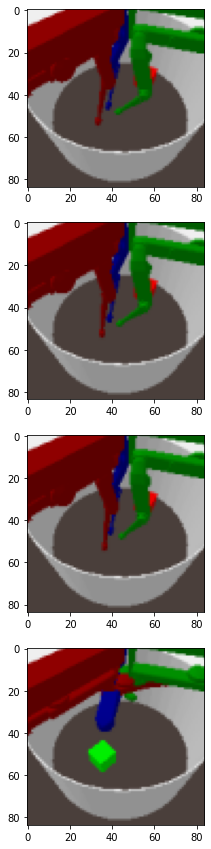

In [145]:
RGB = True
random = np.random.randint(10000)
sample = eval_obs[random]
plot_obs(sample, 1, RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 12, 84, 84)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


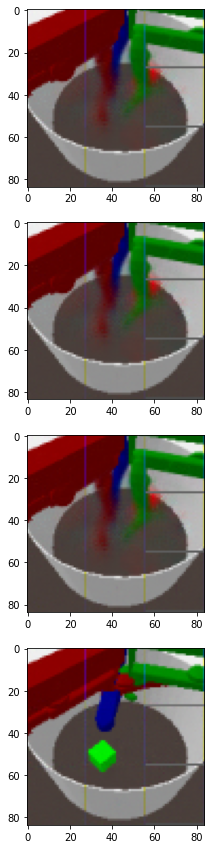

In [146]:
sample = torch.FloatTensor(sample/255.0)
sample = sample.view(-1, 12, 84, 84)
z ,_, _ = encoder(sample.to(device))
recons = decoder(z)


recons = recons.detach().cpu().numpy()
plot_obs(recons, 1, RGB)